In [11]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import PIL
from PIL import Image
import scipy.misc
import random
import pandas as pd
import tensorflow as tf
import h5py
import math


Loading Data:

In [3]:
#loading data
# test_bbox = pickle.load( open( "test_bbox.pickle", "rb" ) )

# train_bbox = pickle.load( open( "train_bbox.pickle", "rb" ) )
train_data = pickle.load( open( "train_data_part4.pickle", "rb" ) )
test_data = pickle.load( open( "test_data_part4.pickle", "rb" ) )



Testing fidelity of data and bounding box correctness.  AND removing any numbers greater than 5 digits.  There is one with 6.


data is in format [[image arr, label, bb]....]

bbox is in this order [ y_top, y_bot, x_left, x_right]

In [4]:
train_data[0][:]

(array([[ 0.42352941,  0.41568627,  0.41960784, ...,  1.        ,
          1.        ,  1.        ],
        [ 0.43921569,  0.43529412,  0.43921569, ...,  1.        ,
          1.        ,  1.        ],
        [ 0.46666667,  0.4627451 ,  0.45490196, ...,  1.        ,
          1.        ,  1.        ],
        ..., 
        [ 0.03921569,  0.04313725,  0.07843137, ...,  1.        ,
          1.        ,  1.        ],
        [ 0.04313725,  0.04705882,  0.08235294, ...,  1.        ,
          1.        ,  1.        ],
        [ 0.04705882,  0.05098039,  0.08627451, ...,  1.        ,
          1.        ,  1.        ]]),
 '19',
 [14.08, 54.857142857142854, 21.246963562753038, 36.1889338731444])

/Users/jdschonhoft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  from ipykernel import kernelapp as app
/Users/jdschonhoft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  app.launch_new_instance()


bounding box:  [2.3703703703703702, 59.25925925925926, 17.723076923076924, 45.784615384615385]
image number:  38


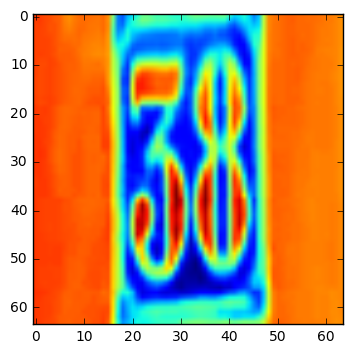

/Users/jdschonhoft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


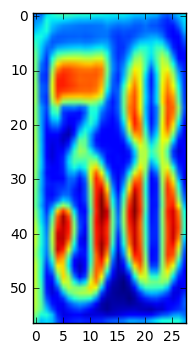

In [5]:
#remove images
train_ = filter(lambda x: x[0] != 'nodata', train_data)
test_ = filter(lambda x: x[0] != 'nodata', test_data)

#removing data if digit greater than 5
train_ = filter(lambda x: len(x[1]) < 6, train_)
test_ = filter(lambda x: len(x[1]) < 6, test_)

imgnumber = 861
bb = train_data[imgnumber][2]
print('bounding box: ', train_data[imgnumber][2])
print('image number: ', train_data[imgnumber][1])
plt.imshow(train_data[imgnumber][0])
plt.show()
plt.imshow(train_data[imgnumber][0][bb[0]:bb[1], bb[2] : bb[3]])
plt.show()

5


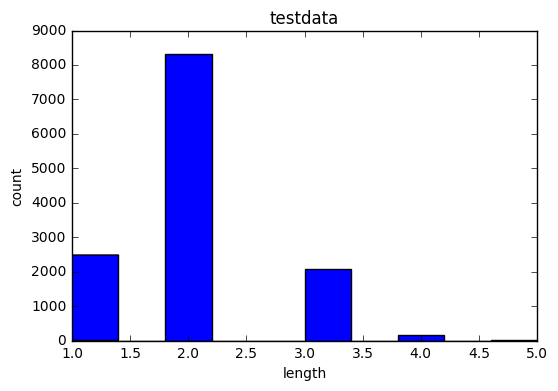

5


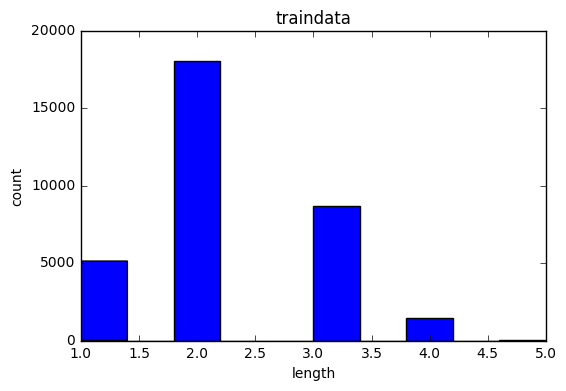

In [6]:
labels = zip(*test_)[1]
labels = [len(i) for i in labels]
print(max(labels))
plt.hist(labels)
plt.xlabel('length')
plt.ylabel('count')
plt.title('testdata')
plt.show()

labels = zip(*train_)[1]
labels = [len(i) for i in labels]
print(max(labels))
plt.hist(labels)
plt.xlabel('length')
plt.ylabel('count')
plt.title('traindata')
plt.show()

Idea is to have a bounding box, that locates the digit to the nearest 10th pixel.  So for a 64x64 image, the location is essentially on a scaled 6x6 grid 

bounding box:  [ 0.  6.  1.  5.] x 10
image number:  [ 2  3  8 10 10 10]


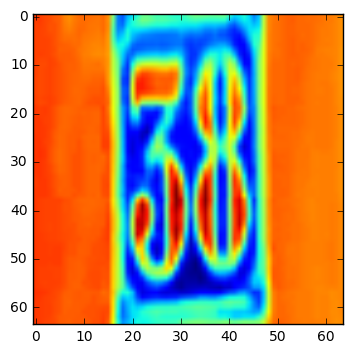

/Users/jdschonhoft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


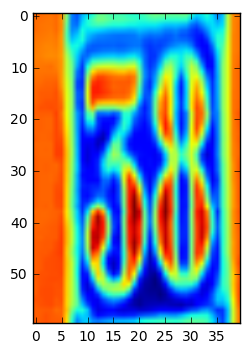

In [7]:
# #training on mnist first
train_dataset = np.array(zip(*train_)[0]).astype(dtype=np.float32)
train_labels = np.array([[len(i)] + [int(k) for k in i] + [int(10)]*(5-len(i)) for i in zip(*train_)[1]])
train_bb = np.array([ [np.floor(i[0]/10.), np.ceil(i[1]/10.), np.floor(i[2]/10.), np.ceil(i[3]/10.)] for i in zip(*train_)[2]]) #expands bounding box to nearest integer


# #training on mnist first
valid_dataset = np.array(zip(*train_)[0]).astype(dtype=np.float32)
valid_labels = np.array([[len(i)] + [int(k) for k in i] + [int(10)]*(5-len(i)) for i in zip(*train_)[1]])
valid_bb = np.array([ [np.floor(i[0]/10.), np.ceil(i[1]/10.), np.floor(i[2]/10.), np.ceil(i[3]/10.)] for i in zip(*train_)[2]]) #expands bounding box to nearest integer


# #training on mnist first
test_dataset = np.array(zip(*test_)[0]).astype(dtype=np.float32)
test_labels = np.array([[len(i)] + [int(k) for k in i] + [int(10)]*(5-len(i)) for i in zip(*test_)[1]])
test_bb = np.array([ [np.floor(i[0]/10.), np.ceil(i[1]/10.), np.floor(i[2]/10.), np.ceil(i[3]/10.)] for i in zip(*test_)[2]]) #expands bounding box to nearest integer




imgnumber = 861
bb = train_bb[imgnumber]
print('bounding box: ', bb, 'x 10')
print('image number: ', train_labels[imgnumber])
plt.imshow(train_[imgnumber][0])
plt.show()
plt.imshow(train_[imgnumber][0][bb[0]*10.:bb[1]*10., bb[2]*10. : bb[3]*10.])
plt.show()

Now reformatting data for tensorflow.  Note that the images are still being fed into tensor flow without any cropping.

In [8]:
image_size = 64
num_labels = 11  #0-9 + blank
num_channels = 1 # grayscale


def reformat(dataset, labels, bbox):
    dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
    return dataset, labels, bbox
train_dataset, train_labels, train_bbox = reformat(train_dataset, train_labels, train_bb)
valid_dataset, valid_labels, valid_bbox = reformat(valid_dataset, valid_labels, valid_bb)
test_dataset, test_labels, test_bbox = reformat(test_dataset, test_labels, valid_bb)

print('Training set', train_dataset.shape, train_labels.shape, train_bbox.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape, valid_bbox.shape)
print('Test set', test_dataset.shape, test_labels.shape, test_bbox.shape)

Training set (33234, 64, 64, 1) (33234, 6) (33234, 4)
Validation set (33234, 64, 64, 1) (33234, 6) (33234, 4)
Test set (13027, 64, 64, 1) (13027, 6) (33234, 4)


In [19]:
import math
#accuracy functions
def accuracy(predictions, labels, batch_size):
    pred = [''.join(np.array(i, dtype = int).astype(str)) for i in predictions]
    lab = [''.join(np.array(i, dtype = int).astype(str)) for i in labels]
    correct = sum([np.array(lab[i]==pred[i]).astype(int) for i in range(len(lab))])/float(batch_size)
    return correct*100.

def accuracy_by_digit(predictions, labels): 
    predictions = np.array(predictions)[:,:]
    lab = np.array(labels)
    correct_matrix = [(np.array(predictions).T[i] == np.array(lab).T[i]).astype(int) for i in range(len(np.array(predictions).T))]
    percent_correct = [np.mean(i) for i in correct_matrix]
    return percent_correct

#parameters
batch_size = 16
image_size = 64
num_labels = 11
patch_size = 3
d1 = 16
d2 = 32
d3 = 64
d4 = 128
sdev = math.sqrt(2.0 / (32**2*1))


#tensorflow computational graph
graph = tf.Graph()
with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size, image_size, 1))
    tf_train_labels = tf.placeholder(tf.int64, shape=(batch_size,6))
    tf_train_bbox = tf.placeholder(tf.int64, shape=(batch_size,4))
    tf_eval = tf.placeholder(tf.float32,shape=(batch_size, image_size, image_size, 1))

    # Variables.
    
    conv1_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, 1, d1], stddev=sdev))
    conv1_b = tf.Variable(tf.zeros([d1]))
    
    conv2_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d1, d2], stddev=sdev))
    conv2_b = tf.Variable(tf.zeros([d2]))
    
    conv3_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d2, d3], stddev=sdev))
    conv3_b = tf.Variable(tf.zeros([d3]))
    
    conv4_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d3, d4], stddev=sdev))
    conv4_b = tf.Variable(tf.zeros([d4]))
    
    fc1_w = tf.Variable(tf.truncated_normal([2048,64], stddev=0.1))
    fc1_b = tf.Variable(tf.constant(1.0, shape=[64]))
    

    #for final logits
    hidden = 2048
    s1_w = tf.get_variable('s1_w', shape=[hidden, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    s1_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    s2_w = tf.get_variable('s2_w',shape=[hidden, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    s2_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    s3_w = tf.get_variable('s3_w',shape=[hidden, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    s3_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    s4_w = tf.get_variable('s4_w',shape=[hidden, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    s4_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    s5_w = tf.get_variable('s5_w',shape=[hidden, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    s5_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
#     #boundboxes
#     d1_bb = 1
#     d2_bb = 2
#     conv1_w_bb = tf.Variable(tf.truncated_normal([patch_size, patch_size, 1, d1_bb], stddev=sdev))
#     conv1_b_bb = tf.Variable(tf.zeros([d1_bb]))
    
#     conv2_w_bb = tf.Variable(tf.truncated_normal([patch_size, patch_size, d1_bb, d2_bb], stddev=sdev))
#     conv2_b_bb = tf.Variable(tf.zeros([d2_bb]))
    
#     fc1_w_bb = tf.Variable(tf.truncated_normal([512,128], stddev=0.1))
#     fc1_b_bb = tf.Variable(tf.constant(1.0, shape=[64]))
    

    #for final logits
    hidden2 = 2048
    b1_w = tf.get_variable('b1_w', shape=[hidden2, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    b1_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    b2_w = tf.get_variable('b2_w',shape=[hidden2, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    b2_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    b3_w = tf.get_variable('b3_w',shape=[hidden2, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    b3_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    b4_w = tf.get_variable('b4_w',shape=[hidden2, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    b4_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))

    
    
    # Model.
    def model(data):
        '''
        Our best architecture consists of eight convolutional hidden layers
        one locally connected hidden layer, and two densely connected hidden layers.
        All connections are feedforward and go from one layer to the next (no skip connections).
        The first hidden layer contains maxout units (Goodfellow et al., 2013) (with three filters per unit)
        while the others contain rectifier units (Jarrett et al., 2009; Glorot et al., 2011). 
        The number of units at each spatial location in each layer is [48, 64, 128, 160] 
        for the first four layers and 192 for all other locally connected layers. 
        The fully connected layers contain 3,072 units each. 
        Each convolutional layer includes max pooling and subtractive normalization. 
        The max pooling window size is 2 × 2. 
        The stride alternates between 2 and 1 at each layer, 
        so that half of the layers don’t reduce the spatial size of the representation. 
        All convolutions use zero padding on the input to preserve representation size. 
        The subtractive normalization operates on 3x3 windows and preserves representation size. 
        All convolution kernels were of size 5 × 5. 
        We trained with dropout applied to all hidden layers but not the input.
        '''

        conv1 = tf.nn.conv2d(data, conv1_w, [1, 1, 1, 1], padding='SAME')
        conv1 = tf.nn.relu(conv1 + conv1_b)
        conv1 = tf.nn.max_pool(conv1, [1,2,2,1], [1,2,2,1], padding='SAME')

        conv2 = tf.nn.conv2d(conv1, conv2_w, [1, 1, 1, 1], padding='SAME')
        conv2 = tf.nn.relu(conv2 + conv2_b)
        conv2 = tf.nn.max_pool(conv2, [1,2,2,1], [1,2,2,1], padding='SAME')

        conv3 = tf.nn.conv2d(conv2, conv3_w, [1, 1, 1, 1], padding='SAME')
        conv3 = tf.nn.relu(conv3 + conv3_b)
        conv3 = tf.nn.max_pool(conv3, [1,2,2,1], [1,2,2,1], padding='SAME')

        conv4 = tf.nn.conv2d(conv3, conv4_w, [1, 1, 1, 1], padding='SAME')
        conv4 = tf.nn.relu(conv4 + conv4_b)
        conv4 = tf.nn.max_pool(conv4, [1,2,2,1], [1,2,2,1], padding='SAME')
        shape = conv4.get_shape().as_list()
        reshape = tf.reshape(conv4, [shape[0], shape[1] * shape[2] * shape[3]])  
        fc1 = tf.nn.dropout(reshape, keep_prob = 0.8)
        
        
        #bounding box
        shape_bb = conv4.get_shape().as_list()
        reshape_bb = tf.reshape(conv4, [shape_bb[0], shape_bb[1] * shape_bb[2] * shape_bb[3]])  
        fc1_bb = tf.nn.dropout(reshape_bb, keep_prob = 0.8)
        
        
        #five classifiers for each digit
        s1 = tf.matmul(fc1, s1_w) + s1_b
        s2 = tf.matmul(fc1, s2_w) + s2_b
        s3 = tf.matmul(fc1, s3_w) + s3_b
        s4 = tf.matmul(fc1, s4_w) + s4_b
        s5 = tf.matmul(fc1, s5_w) + s5_b
        
        #four classifiers for the bounding box, locating the number in the image
        b1 = tf.matmul(fc1_bb, b1_w) + b1_b
        b2 = tf.matmul(fc1_bb, b2_w) + b2_b
        b3 = tf.matmul(fc1_bb, b3_w) + b3_b
        b4 = tf.matmul(fc1_bb, b4_w) + b4_b
        
        return [s1, s2, s3, s4, s5, b1, b2, b3, b4]

 
    # Training computation. #no length logit
    [s1, s2, s3, s4, s5, b1, b2, b3, b4] = model(tf_train_dataset)
    
    
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(s1, tf_train_labels[:,1])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(s2, tf_train_labels[:,2])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(s3, tf_train_labels[:,3])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(s4, tf_train_labels[:,4])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(s5, tf_train_labels[:,5])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(b1, tf_train_bbox[:,0])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(b2, tf_train_bbox[:,1])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(b3, tf_train_bbox[:,2])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(b4, tf_train_bbox[:,3]))



    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()

    # Optimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.00025).minimize(loss) 
    
    # Predictions for the training and evaluation data
    train_prediction = tf.pack([tf.nn.softmax(s1),
                      tf.nn.softmax(s2),
                      tf.nn.softmax(s3),
                      tf.nn.softmax(s4),
                      tf.nn.softmax(s5),
                      tf.nn.softmax(b1),
                      tf.nn.softmax(b2),
                      tf.nn.softmax(b3),
                      tf.nn.softmax(b4)])
    
    eval_prediction = tf.pack([tf.nn.softmax(model(tf_eval)[0]),
                             tf.nn.softmax(model(tf_eval)[1]),
                             tf.nn.softmax(model(tf_eval)[2]),
                             tf.nn.softmax(model(tf_eval)[3]),
                             tf.nn.softmax(model(tf_eval)[4]),
                             tf.nn.softmax(model(tf_eval)[5]),
                             tf.nn.softmax(model(tf_eval)[6]),
                             tf.nn.softmax(model(tf_eval)[7]),
                             tf.nn.softmax(model(tf_eval)[8]),])

    test_prediction = tf.pack([tf.nn.softmax(model(test_dataset)[0]),
                     tf.nn.softmax(model(test_dataset)[1]),
                     tf.nn.softmax(model(test_dataset)[2]),
                     tf.nn.softmax(model(test_dataset)[3]),
                     tf.nn.softmax(model(test_dataset)[4]),
                     tf.nn.softmax(model(test_dataset)[5]),
                     tf.nn.softmax(model(test_dataset)[6]),
                     tf.nn.softmax(model(test_dataset)[7]),
                     tf.nn.softmax(model(test_dataset)[8]),])

In [ ]:
num_steps = 1000001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    
    step_t = []
    loss_t = []
    acc_t = []
    
    for step in range(num_steps):
        offset = random.randint(0,len(train_dataset)-batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        batch_bb = train_bbox[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_train_bbox : batch_bb}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 500 == 0):
            pred = [list(tf.argmax(predictions[:,i,:],1).eval()) for i in range(batch_size)]
            digits = batch_labels[:,1:]
            bbox = batch_bb
            labels = np.hstack((np.array(digits), np.array(batch_bb))).astype(int)
            
            step_t.append(step)
            loss_t.append(l)
            acc_t.append(accuracy_by_digit(pred, labels)[0:5])
        
        if (step % 5000 == 0):
            
            print(step)
            pred = [list(tf.argmax(predictions[:,i,:],1).eval()) for i in range(batch_size)]
            digits = batch_labels[:,1:]
            bbox = batch_bb
            labels = np.hstack((np.array(digits), np.array(batch_bb))).astype(int)
            accuracy_digit = accuracy_by_digit(pred, labels)
            
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch digit accuracy at step %d: %f' % (step, accuracy(np.array(pred)[0:,0:5], np.array(labels)[0:,0:5], batch_size)))
            print('Minibatch accuracy by digit - bbox:', accuracy_digit)

            print('Minibatch Predictions')
            print(np.array(pred).T)
            print('Minibatch Labels')
            print(np.array(labels).T)
            
            save_path = saver.save(session, os.getcwd() + '/STEP4_model2.ckpt')
            print("Model saved in file: %s" % save_path)
    
    #figures
    #figures
    plt.figure(1)
    plt.plot(step_t[1:], loss_t[1:], label = 'loss')
    plt.xlabel('step')
    plt.ylabel('loss')
    plt.legend()

    plt.figure(2)
    acc_T = np.array(acc_t).T
    acc_T = [list(i) for i in acc_T]
    k = 0
    for i in acc_T:
        k = k + 1
        plt.plot(step_t, i, label = 'digit' + str(k))
    plt.xlabel('step')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()
    
    save_path = saver.save(session, os.getcwd() + '/STEP4_model2.ckpt')
    print("Model saved in file: %s" % save_path)
#     pred = test_prediction.eval()
# #     print('Test accuracy: %.1f%%' % accuracy(pred, test_labels[:,1:]))
# #     print([list(tf.argmax(test_prediction[:,i,:],1).eval()) for i in range(batch_size)])
#     print(test_prediction[:,i,:],1).eval().get_shape()

Initialized
0
Minibatch loss at step 0: 21.616817
Minibatch digit accuracy at step 0: 0.000000
Minibatch accuracy by digit - bbox: [0.0625, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0625, 0.0]
Minibatch Predictions
[[ 0  0  7  0  0  3  7  7  0  9  0  7  0  0  0  7]
 [ 5  5  5  5  5  5  5  5  5  5  2  5  5  5  5  5]
 [ 8  6  8  9  8  9  8  9  9  8  9  9  8  9  8  9]
 [ 9  9  8  9  9  9  8  9  9  9  9  9  8  4  9  8]
 [ 7  3  3  3  3  3  7  3  0  7 10  3  7  3  3  3]
 [ 3  8  8  2  3  3  3  3  3  3  3  3  3  2  3  3]
 [ 2  2  2  5  5 10  2  2  5  2  2 10  2 10  2  5]
 [ 4  4  4  4  4  1  4  4  4  4  4  4  4  4  4  4]
 [ 8  8  2  8  2  2  0  2  2  6  2  2  6  2  8  2]]
Minibatch Labels
[[ 2  3  7  1  1  2  5  3  3  3  9  6  8  1  3  4]
 [ 1  1  0  0  2  6  9  2  1  3 10 10 10  2  0  3]
 [10 10  0 10 10  3 10 10 10 10 10 10 10 10  5 10]
 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
 [ 0  0  0  1  1  0  0  1  1  1  2  0  0  0  1  0]
 [ 6  6  

Now checking test images

In [24]:

def predict_with_model(y, model_name, test_size):

    test_dataset = y
    #parameters
    batch_size = 16
    image_size = 64
    num_labels = 11
    patch_size = 3
    d1 = 16
    d2 = 32
    d3 = 64
    d4 = 128
    sdev = math.sqrt(2.0 / (32**2*1))


    #tensorflow computational graph
    graph = tf.Graph()
    with graph.as_default():

        # Input data.
        tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size, image_size, 1))
        tf_train_labels = tf.placeholder(tf.int64, shape=(batch_size,6))
        tf_train_bbox = tf.placeholder(tf.int64, shape=(batch_size,4))
        tf_eval = tf.placeholder(tf.float32,shape=(batch_size, image_size, image_size, 1))

        # Variables.

        conv1_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, 1, d1], stddev=sdev))
        conv1_b = tf.Variable(tf.zeros([d1]))

        conv2_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d1, d2], stddev=sdev))
        conv2_b = tf.Variable(tf.zeros([d2]))

        conv3_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d2, d3], stddev=sdev))
        conv3_b = tf.Variable(tf.zeros([d3]))

        conv4_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d3, d4], stddev=sdev))
        conv4_b = tf.Variable(tf.zeros([d4]))

        fc1_w = tf.Variable(tf.truncated_normal([2048,64], stddev=0.1))
        fc1_b = tf.Variable(tf.constant(1.0, shape=[64]))


        #for final logits
        hidden = 2048
        s1_w = tf.get_variable('s1_w', shape=[hidden, num_labels],initializer=tf.contrib.layers.xavier_initializer())
        s1_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
        s2_w = tf.get_variable('s2_w',shape=[hidden, num_labels],initializer=tf.contrib.layers.xavier_initializer())
        s2_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
        s3_w = tf.get_variable('s3_w',shape=[hidden, num_labels],initializer=tf.contrib.layers.xavier_initializer())
        s3_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
        s4_w = tf.get_variable('s4_w',shape=[hidden, num_labels],initializer=tf.contrib.layers.xavier_initializer())
        s4_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
        s5_w = tf.get_variable('s5_w',shape=[hidden, num_labels],initializer=tf.contrib.layers.xavier_initializer())
        s5_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))

    #     #boundboxes
    #     d1_bb = 1
    #     d2_bb = 2
    #     conv1_w_bb = tf.Variable(tf.truncated_normal([patch_size, patch_size, 1, d1_bb], stddev=sdev))
    #     conv1_b_bb = tf.Variable(tf.zeros([d1_bb]))

    #     conv2_w_bb = tf.Variable(tf.truncated_normal([patch_size, patch_size, d1_bb, d2_bb], stddev=sdev))
    #     conv2_b_bb = tf.Variable(tf.zeros([d2_bb]))

    #     fc1_w_bb = tf.Variable(tf.truncated_normal([512,128], stddev=0.1))
    #     fc1_b_bb = tf.Variable(tf.constant(1.0, shape=[64]))


        #for final logits
        hidden2 = 2048
        b1_w = tf.get_variable('b1_w', shape=[hidden2, num_labels],initializer=tf.contrib.layers.xavier_initializer())
        b1_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
        b2_w = tf.get_variable('b2_w',shape=[hidden2, num_labels],initializer=tf.contrib.layers.xavier_initializer())
        b2_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
        b3_w = tf.get_variable('b3_w',shape=[hidden2, num_labels],initializer=tf.contrib.layers.xavier_initializer())
        b3_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
        b4_w = tf.get_variable('b4_w',shape=[hidden2, num_labels],initializer=tf.contrib.layers.xavier_initializer())
        b4_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))



        # Model.
        def model(data):
            '''
            Our best architecture consists of eight convolutional hidden layers
            one locally connected hidden layer, and two densely connected hidden layers.
            All connections are feedforward and go from one layer to the next (no skip connections).
            The first hidden layer contains maxout units (Goodfellow et al., 2013) (with three filters per unit)
            while the others contain rectifier units (Jarrett et al., 2009; Glorot et al., 2011). 
            The number of units at each spatial location in each layer is [48, 64, 128, 160] 
            for the first four layers and 192 for all other locally connected layers. 
            The fully connected layers contain 3,072 units each. 
            Each convolutional layer includes max pooling and subtractive normalization. 
            The max pooling window size is 2 × 2. 
            The stride alternates between 2 and 1 at each layer, 
            so that half of the layers don’t reduce the spatial size of the representation. 
            All convolutions use zero padding on the input to preserve representation size. 
            The subtractive normalization operates on 3x3 windows and preserves representation size. 
            All convolution kernels were of size 5 × 5. 
            We trained with dropout applied to all hidden layers but not the input.
            '''

            conv1 = tf.nn.conv2d(data, conv1_w, [1, 1, 1, 1], padding='SAME')
            conv1 = tf.nn.relu(conv1 + conv1_b)
            conv1 = tf.nn.max_pool(conv1, [1,2,2,1], [1,2,2,1], padding='SAME')

            conv2 = tf.nn.conv2d(conv1, conv2_w, [1, 1, 1, 1], padding='SAME')
            conv2 = tf.nn.relu(conv2 + conv2_b)
            conv2 = tf.nn.max_pool(conv2, [1,2,2,1], [1,2,2,1], padding='SAME')

            conv3 = tf.nn.conv2d(conv2, conv3_w, [1, 1, 1, 1], padding='SAME')
            conv3 = tf.nn.relu(conv3 + conv3_b)
            conv3 = tf.nn.max_pool(conv3, [1,2,2,1], [1,2,2,1], padding='SAME')

            conv4 = tf.nn.conv2d(conv3, conv4_w, [1, 1, 1, 1], padding='SAME')
            conv4 = tf.nn.relu(conv4 + conv4_b)
            conv4 = tf.nn.max_pool(conv4, [1,2,2,1], [1,2,2,1], padding='SAME')
            shape = conv4.get_shape().as_list()
            reshape = tf.reshape(conv4, [shape[0], shape[1] * shape[2] * shape[3]])  
            fc1 = tf.nn.dropout(reshape, keep_prob = 0.8)


            #bounding box
            shape_bb = conv4.get_shape().as_list()
            reshape_bb = tf.reshape(conv4, [shape_bb[0], shape_bb[1] * shape_bb[2] * shape_bb[3]])  
            fc1_bb = tf.nn.dropout(reshape_bb, keep_prob = 0.8)


            #five classifiers for each digit
            s1 = tf.matmul(fc1, s1_w) + s1_b
            s2 = tf.matmul(fc1, s2_w) + s2_b
            s3 = tf.matmul(fc1, s3_w) + s3_b
            s4 = tf.matmul(fc1, s4_w) + s4_b
            s5 = tf.matmul(fc1, s5_w) + s5_b

            #four classifiers for the bounding box, locating the number in the image
            b1 = tf.matmul(fc1_bb, b1_w) + b1_b
            b2 = tf.matmul(fc1_bb, b2_w) + b2_b
            b3 = tf.matmul(fc1_bb, b3_w) + b3_b
            b4 = tf.matmul(fc1_bb, b4_w) + b4_b

            return [s1, s2, s3, s4, s5, b1, b2, b3, b4]


        # Training computation. #no length logit
        [s1, s2, s3, s4, s5, b1, b2, b3, b4] = model(tf_train_dataset)


        loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(s1, tf_train_labels[:,1])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(s2, tf_train_labels[:,2])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(s3, tf_train_labels[:,3])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(s4, tf_train_labels[:,4])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(s5, tf_train_labels[:,5])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(b1, tf_train_bbox[:,0])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(b2, tf_train_bbox[:,1])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(b3, tf_train_bbox[:,2])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(b4, tf_train_bbox[:,3]))



        # Add ops to save and restore all the variables.
        saver = tf.train.Saver()

        # Optimizer.
        optimizer = tf.train.AdamOptimizer(learning_rate = 0.00025).minimize(loss) 

        # Predictions for the training and evaluation data
        train_prediction = tf.pack([tf.nn.softmax(s1),
                          tf.nn.softmax(s2),
                          tf.nn.softmax(s3),
                          tf.nn.softmax(s4),
                          tf.nn.softmax(s5),
                          tf.nn.softmax(b1),
                          tf.nn.softmax(b2),
                          tf.nn.softmax(b3),
                          tf.nn.softmax(b4)])

        eval_prediction = tf.pack([tf.nn.softmax(model(tf_eval)[0]),
                                 tf.nn.softmax(model(tf_eval)[1]),
                                 tf.nn.softmax(model(tf_eval)[2]),
                                 tf.nn.softmax(model(tf_eval)[3]),
                                 tf.nn.softmax(model(tf_eval)[4]),
                                 tf.nn.softmax(model(tf_eval)[5]),
                                 tf.nn.softmax(model(tf_eval)[6]),
                                 tf.nn.softmax(model(tf_eval)[7]),
                                 tf.nn.softmax(model(tf_eval)[8]),])

        test_prediction = tf.pack([tf.nn.softmax(model(test_dataset)[0]),
                         tf.nn.softmax(model(test_dataset)[1]),
                         tf.nn.softmax(model(test_dataset)[2]),
                         tf.nn.softmax(model(test_dataset)[3]),
                         tf.nn.softmax(model(test_dataset)[4]),
                         tf.nn.softmax(model(test_dataset)[5]),
                         tf.nn.softmax(model(test_dataset)[6]),
                         tf.nn.softmax(model(test_dataset)[7]),
                         tf.nn.softmax(model(test_dataset)[8]),])

        with tf.Session(graph=graph) as sess:

            sess.run(tf.initialize_all_variables())
            saver.restore(sess, os.getcwd() + model_name)

            pred = [(tf.argmax(test_prediction[:,i,:],1).eval()) for i in range(test_size)]

            return pred

test_size = 500
y = test_dataset[0:test_size]
predictions = predict_with_model(y, '/STEP4_model2.ckpt', test_size)
predictions = np.array(predictions)[:, 0:5]
d_accur = accuracy_by_digit(predictions, test_labels[:test_size,1:])
accur = accuracy(predictions, test_labels[:test_size,1:], test_size)
k = 1
for i in d_accur:
    print('digit ', k, ': ', i)
    k = k + 1
print('overall accuracy: ', accur)

digit  1 :  0.45
digit  2 :  0.392
digit  3 :  0.718
digit  4 :  0.984
digit  5 :  1.0
overall accuracy:  22.8
